# Data challenge 1 to data challenge 2

By JM. Colley CNRS/IN2P3/LPHNE, France. Dec 2022


## GRANDLIB installation
In last version of GRANDLIB package,there is a reorganization of the code and to avoid the presence of unused empty directory, it is advisable to perform a git clone rather than a git fetch/pull.
See [here](https://github.com/grand-mother/grand/wiki) the installation procedure.


## DC1 : processing Efield data in ROOT format

Find [here](https://github.com/grand-mother/data_challenge1/blob/main/README.md) the information of Data Challenge 1 (DC1)

### Inputs data model
All data model are automatically loaded at package initialization, ie
```bash
grand# source env/setup.sh 
Set var GRAND_ROOT=/home/dc1/docapi/grand
==============================
add grand/quality to PATH
==============================
...

==============================
Download data model (~ 1GB) for GRAND, please wait ...
Successfully downloaded
==============================
Extract tar file
data model available in grand/data/model directory !
grand#
```
in /grand/data directory

```bash
grand# tree data
data
├── download_data_grand.py
├── grand_model_2207.tar.gz
├── model
│   ├── detector
│   │   ├── GP300Antenna_EWarm_leff.npy
│   │   ├── GP300Antenna_SNarm_leff.npy
│   │   ├── GP300Antenna_Zarm_leff.npy
│   │   ├── HorizonAntenna_EWarm_leff_loaded.npy
│   │   ├── HorizonAntenna_SNarm_leff_loaded.npy
│   │   ├── HorizonAntenna_Zarm_leff_loaded.npy
│   │   ├── LNASparameter
│   │   │   ├── 1.s2p
│   │   │   ├── 2.s2p
│   │   │   └── 3.s2p
│   │   ├── antennaVSWR
│   │   │   ├── 1.s1p
│   │   │   ├── 2.s1p
│   │   │   └── 3.s1p
│   │   ├── cableparameter
│   │   │   └── cable.s2p
│   │   └── filterparameter
│   │       └── 1.s2p
│   └── sky
│       └── 30_250galactic.mat
└── readme.md
```

### Inputs data Efield
[Coarse files](https://github.com/grand-mother/data_challenge1/tree/main/coarse_subei_traces_root) created for DC1 aren't usuable, see this [issue](https://github.com/grand-mother/collaboration-issues/issues/14). Only the file [Coarse2_xmax_add.root](https://github.com/grand-mother/data_challenge1/blob/main/coarse_subei_traces_root/Coarse2_xmax_add.root) can be processed correctly but a trace centering problem exists, see this [issue](https://github.com/grand-mother/collaboration-issues/issues/15).

You can plot trace and footprint with script `grand_ioroot.py`, the documentation is in grand/script/readme.md

**Example:**
![c2_efieild_du7.png](./c2_efieild_du7.png)

### How process Efield data file
You can process Efield data with the script `grand_simu_du.py`, the documentation is in grand/script/readme.md

```bash
/grand# grand_simu_du.py Coarse2_xmax_add.root-o c2_test.root 
```

**WARNING:**
You can't choice as output the input file.

You can plot trace and footprint with script `grand_ioroot.py`, the documentation is in grand/script/readme.md, with specific option `--ttree voltage`

**Example:**
![c2_volt_du7.png](./c2_volt_du7.png)


## Toward data challenge 2

### Read data from DC1

#### With grand/io/root_trees.py

See documentation mentionned in [Data Challenge 1](https://github.com/grand-mother/data_challenge1/blob/main/README.md) package.


#### With grand/io/root_files.py

In [1]:
import grand.io.root_files as grf

Welcome to JupyROOT 6.26/02


The traces are stored in numpy array

In [2]:
fv = grf.FileVoltageEvent("c2_test.root")
fv.traces.shape

(96, 3, 999)

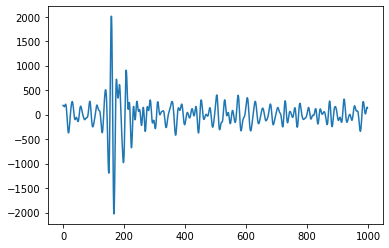

In [3]:
import matplotlib.pyplot as plt

plt.plot(fv.traces[50, 0])

FileVoltageEvent is still a data class wihtout feature to handle trace, to do that you can use the specific class for traces 3D: `Handling3dTracesOfEvent()` in grand.basis.traces_event.py package

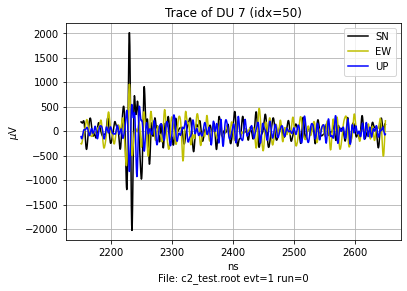

In [7]:
handle_tr = fv.get_obj_handling3dtraces()
handle_tr.plot_trace_idx(50)

As you can see, this class retrieves the correct unit, the time associated to sample in nanoseconds and allow to use index in array or DU identifier. For example, we can plot trace of DU 7, same plot as above.

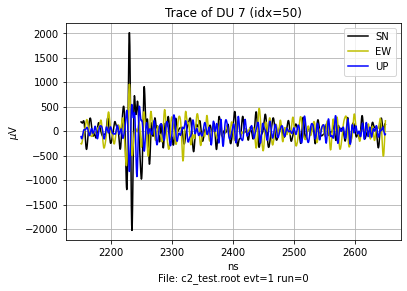

In [8]:
handle_tr.plot_trace_du(7)

You can also, plot footprint with different value

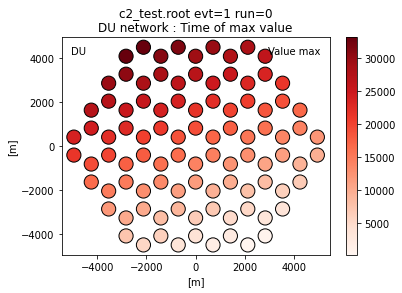

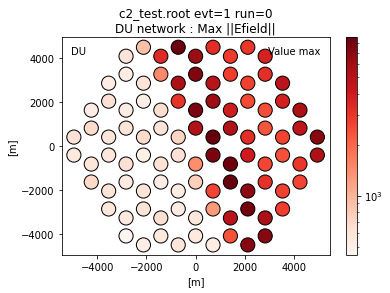

In [11]:
handle_tr.plot_footprint_time_max()
handle_tr.plot_footprint_val_max()

If you want learn more on this class, read the docstring with help function in ipython or jupyter notebook:
```bash
help(handle_tr)
```

### Retrieve transfer function of antenna : Effective length
The transfer function depends of the direction of the shower, it is deduced from the position of the antenna and the position of the Xmax. Its calculation mobilizes many features of GRANDLIB and it is coupled with simulation data which makes a simple example difficult to give. It's in fact an attribut of class TabulatedAntennaModel, named: `fft_leff_frame_shower`.
To give you an idea to compute it, from grand/src_outlib/analyse_resp_antenna.py


In [ ]:
from grand import LTP
from grand.simu.du.process_ant import AntennaProcessing
from grand.io.file_leff import TabulatedAntennaModel
from grand import grand_add_path_data_model
from grand.simu.shower.gen_shower import ShowerEvent

G_path_ant_300 = grand_add_path_data_model("detector/GP300Antenna_EWarm_leff.npy")
G_r_ant = TabulatedAntennaModel.load(G_path_ant_300)


def plot_kernel_resp_ant():
    # Load the radio shower simulation data
    showerdir = osp.join(grand_get_path_root_pkg(), "tests/simulation/data/zhaires")
    shower = ShowerEvent.load(showerdir)
    # print(shower.fields.keys())
    field = shower.fields[0]
    antpos_wrt_shower = field.electric.pos_xyz
    # RK: if antenna location was saved in LTP frame in zhaires.py, next step would not required.
    antenna_location = LTP(
        x=antpos_wrt_shower.x,
        y=antpos_wrt_shower.y,
        z=antpos_wrt_shower.z,
        frame=shower.frame,
    )
    antenna_frame = LTP(
        location=antenna_location,
        orientation="NWU",
        magnetic=True,
        obstime=shower.frame.obstime,
    )
    antenna = AntennaProcessing(G_r_ant, antenna_frame)
    Exyz = field.electric.e_xyz
    logger.info(mlg.chrono_start())
    # Xmax, Efield, and input frame are all in shower frame.
    logger.debug("compute_voltage")
    antenna.compute_voltage(shower.maximum, field.electric, frame=shower.frame)
    # Finaly effective length is stored in attribut
    antenna.fft_leff_frame_shower

### Retrieve transfer function of electronic chain
Much much simpler, the total transfer function of RF chain is provided by the class RfChainGP300 in module grand.simu.du.rf_chain.py, defined the frequency array and call method get_tf_3d() 

Text(0.5, 0, 'MHz')

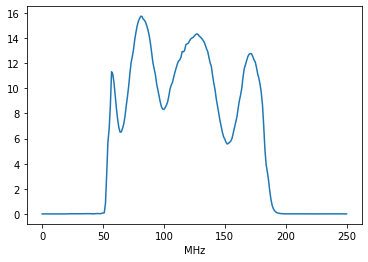

In [14]:
from grand.simu.du.rf_chain import RfChainGP300
import scipy.fft as sf
import matplotlib.pyplot as plt
import numpy as np

out_f = sf.rfftfreq(500, 2e-9) / 1e6
rfchain = RfChainGP300()
rfchain.compute_for_freqs(out_f)
tf = rfchain.get_tf_3d()
plt.plot(out_f, np.abs(tf[0]))
plt.xlabel("MHz")